In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
import pickle
import pyvista as pv

NumExpr defaulting to 8 threads.


In [2]:
with open('ExperimentalData.pkl','rb') as f:
    ExperimentalData = pickle.load(f)

In [3]:
## Pyvista global settings
pv.set_plot_theme("document")
pv.set_jupyter_backend('static')
pv.global_theme.transparent_background = True
pv.global_theme.show_scalar_bar = False

In [4]:
## Matplotlib global settings
plt.rcParams["font.family"] = "ubuntu"
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.labelcolor"] = 'k'
plt.rcParams["axes.labelpad"] = 10
plt.rcParams["legend.fontsize"] = 12
plt.rcParams['xtick.color'] = 'dimgray'
plt.rcParams['ytick.color'] = 'dimgray'

In [5]:
#filePath = r'deploy1/VTK/deployFull1_23138487.vtk'
filePath = r'deploy3/deployFull3/VTK/deployFull3_23138487.vtk'
grid = pv.read(filePath)
#grid

In [6]:
clipPoint  = (0,-0.05,0)
slicePoint = (0,0,0.28)
translatePoint = (0.15, 0, 0)

grid_A = grid.clip(normal='y',origin=clipPoint,invert=False).slice(normal='z',origin=slicePoint)
grid_B = grid_A.copy()
grid_B.translate(translatePoint)

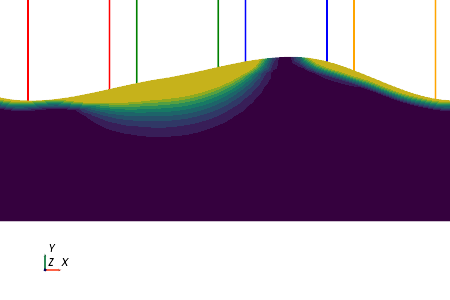

In [7]:
# Initialize plotter
plotter = pv.Plotter(off_screen=False)
plotter.parallel_projection = False
kw_add_mesh = dict(scalars='percentClay',n_colors=10,cmap='viridis',clim=[0.0,0.05])

# Add information to plotter
plotter.add_mesh(grid_A,**kw_add_mesh)
plotter.add_mesh(grid_B,**kw_add_mesh)
plotter.add_axes()

# Add planes
z = slicePoint[2]-0.01
cores_planes = [[pv.Line((x,-0.05,z),(x,0.05,z)) for x in [0.10,0.13]],
                [pv.Line((x,-0.05,z),(x,0.05,z)) for x in [0.14,0.17]],
                [pv.Line((x,-0.05,z),(x,0.05,z)) for x in [0.18,0.21]],
                [pv.Line((x,-0.05,z),(x,0.05,z)) for x in [0.22,0.25]]]

cores_id = ['Core A','Core B','Core C','Core D']
core_color = ['r','g','b','orange']

for core,color in zip(cores_planes,core_color):
    for line in core:
        plotter.add_mesh(line,color=color,line_width=2)

# Camera position
## A list of three points: [eyeposition, focal point, where is up]
## Could also use 'xy', 'xz' etc.
cpos = [(translatePoint[0]*1.15,clipPoint[1]/2,slicePoint[2]*1.7),
        (translatePoint[0]*1.15,clipPoint[1]/2,0),
        (0,1,0)]
#cpos = 'xy'
# Show a snapshot
plotter.show(window_size=[450,300],cpos=cpos,return_img=True)

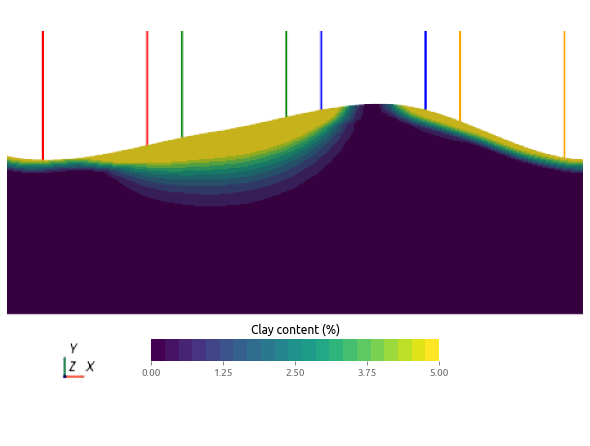

In [8]:
x = np.linspace(0, 5, 100)
cmap = plt.get_cmap('viridis',21)
norm = mpl.colors.Normalize(vmin=0,vmax=0.05*100)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])

fig = plt.figure(figsize=[8,6])
mainax  = fig.add_axes([0, 0, 1, 1],frame_on=False)
ax = fig.add_axes([0, 0, 1, 1],frame_on=False)
cax = fig.add_axes([0.25, 0.18, 0.5, 0.05],frame_on=False)

#hide x-axis
for a in [mainax,ax]:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)

ax.imshow(plotter.image,aspect='equal')
plt.colorbar(sm, cax=cax, ticks=np.linspace(0,0.05*100,5),orientation='horizontal')
cax.set(title='Clay content (%)')
loc = ax.get_window_extent()
plt.show()

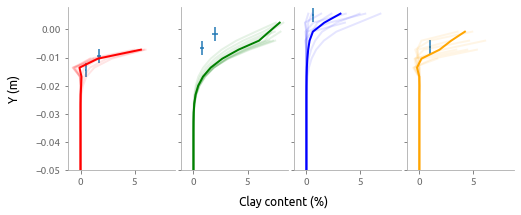

In [9]:
resx = 9
cores_x = [np.linspace(0.10,0.13,resx),
           np.concatenate((np.linspace(0.14,0.15,5),np.linspace(0.01,0.02,4))),
           np.linspace(0.03,0.06,resx),
           np.linspace(0.07,0.10,resx)]

fig,axs = plt.subplots(1,4,sharey=True,sharex=True,gridspec_kw={'wspace':0.05},figsize=[8,3])

for i,core in enumerate(cores_x):
    pC_accum,y_accum = [],[]
    for x in core:
        line_bottom,line_top = (x,-0.10,0.145),(x, 0.06,0.145)
        samples = grid.sample_over_line(line_top,line_bottom,resolution=50)
        pC = np.ma.masked_where(samples['vtkValidPointMask']<1.0,samples['percentClay'])
        pC *= 100
        y  = np.ma.masked_where(samples['vtkValidPointMask']<1.0,samples.points[:,1])
        pC_accum.append(pC)
        y_accum.append(y)
        axs[i].plot(pC,y,color=core_color[i],alpha=0.1,lw=2)
        
    pC_accum = np.ma.stack(pC_accum,axis=0)
    meanPc = pC_accum.mean(axis=0)
    y_accum = np.ma.stack(y_accum,axis=0)
    meanY = y_accum.mean(axis=0)    
    axs[i].plot(meanPc,meanY,color=core_color[i],lw=2)

for ax in axs: 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('darkgray')
    ax.spines['bottom'].set_color('darkgray')
    
axs[0].set_ylim([-0.05,0.008])

fig.supxlabel('Clay content (%)',y=-0.05)
fig.supylabel('Y (m)')

## Measurements
experiment = ExperimentalData['Neutral']
ycores = ExperimentalData['Y']
ccores = ExperimentalData['Neutral']['C']
scores = ExperimentalData['Neutral']['std']

for y,cv,sv,ax in zip(ycores,ccores,scores,axs):
    dy = 0.5E-2
    y1 = y
    y2 = y - dy
    for c,s in zip(cv,sv):
        ax.vlines(c,y2,y1)
        ym = (y1+y2)/2
        ax.hlines(ym,c-s,c+s)
        y1 -= dy
        y2 -= dy

plt.show()

In [10]:
experiment = ExperimentalData['Neutral']

In [11]:
experiment['std']

[[0.22, 0.08], [0.26, 0.15], [0.09], [0.06]]